In [1]:
#I will start out my project by building a neural ODE from scratch (no pytorch, only using basic libraries like numpy, matplotlib, etc.)
#in the other implementation I will use a higher level library like Pytorch, Tensorflow or JAX
#So in this notebook I will implement the neural ODE from scratch and train it on some simple regression task since the adjoint method can be very unstable and dealing with underflow and overflow was really hard. additionally, not using autodiff made training very unstable, which is why i used gradient clipping

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


   
# Integrating Forward in a Neural ODE

To solve the problem of integrating forward in a neural ODE, we need to compute the state of the system at different points in time. The process involves:

1. **Defining the ODE Function**: Represent the time derivative of the system as a neural network:
   $$
   \frac{d\mathbf{h}(t)}{dt} = f(\mathbf{h}(t), t; \theta)
   $$
   where $\mathbf{h}(t)$ is the hidden state at time $t$ and $\theta$ represents the parameters of the neural network.

2. **Choosing an ODE Solver**: Here we are using a RK4 (runge-kutta) ODE solver to integrate forward. The solver computes:
   $$
   \mathbf{h}(t_1) = \mathbf{h}(t_0) + \int_{t_0}^{t_1} f(\mathbf{h}(t), t; \theta) \, dt
   $$
   This integration step is done over the time interval $[t_0, t_1]$ to predict the new state.

3. **Integrating forward and backward with the ODE solver, with the increment hidden state (i.e. vector field) modeled by the neural network**


\
**Here are two great visualizations from the paper Neural Ordinary Differential Equations by Ricky T. Q. Chen et al.:**

1. Here we can can see how the forward pass is given by an ODE solver, that is using a neural network that learns the vector field, and, instead of just doing simple backpropagation, the backward pass is also modeled by the same neural network and ODE solver, although, they are modeling the adjoint variable, which is initialized as the derivative of the Loss. Thats how we figure out the sensitivity of the network parameters of the neural ode:


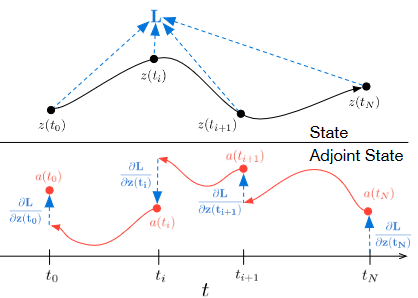



2. Here is another great visualization that shows us how a neural ode is essentially an RNN in continuous time, where the neural ode is giving the vector field that we integrate over with an ODE solver:


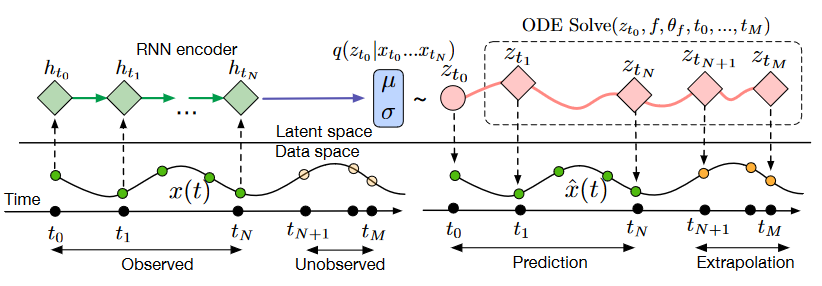




In [3]:
# ----------------------------
# Neural Network Implementation (we will use this as the basis for the neural ode)
# ----------------------------
class NeuralNet:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # I chose Xavier initialization for better gradient flow (after plain stochastic gradient descent failed)
        self.W1 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2.0 / (input_dim + hidden_dim))
        self.b1 = np.zeros((hidden_dim, 1))
        self.W2 = np.random.randn(output_dim, hidden_dim) * np.sqrt(2.0 / (hidden_dim + output_dim))
        self.b2 = np.zeros((output_dim, 1))

        # setting up momentum terms for adam optimization
        self.mW1 = np.zeros_like(self.W1)
        self.mb1 = np.zeros_like(self.b1)
        self.mW2 = np.zeros_like(self.W2)
        self.mb2 = np.zeros_like(self.b2)
        
        # setting up terms for RMSprop
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)
        
        # initializing gradients with zeros
        self.dW1 = np.zeros_like(self.W1)
        self.db1 = np.zeros_like(self.b1)
        self.dW2 = np.zeros_like(self.W2)
        self.db2 = np.zeros_like(self.b2)
        
        # setting the hyperparameters for Adam optimizer
        self.beta1 = 0.9  # Momentum parameter
        self.beta2 = 0.999  # RMSprop parameter
        self.epsilon = 1e-8  # Small constant for numerical stability
        self.t = 0  # Time step for Adam
        

    def forward(self, h, t):
        """
        Forward pass through the neural network with layer normalization
        """
        self.current_h = h
        self.current_t = t
        
        # first layer
        self.z1 = np.dot(self.W1, h) + self.b1
        # layer normalization
        mean1 = np.mean(self.z1, axis=0, keepdims=True)
        var1 = np.var(self.z1, axis=0, keepdims=True) + self.epsilon
        self.z1_norm = (self.z1 - mean1) / np.sqrt(var1)
        self.a1 = np.tanh(self.z1_norm)
        
        # second layer
        self.z2 = np.dot(self.W2, self.a1) + self.b2
        return self.z2

    def zero_grad(self):
        """
        Function for resetting gradients on every iteration so they dont accumulate
        """
        self.dW1.fill(0)
        self.db1.fill(0)
        self.dW2.fill(0)
        self.db2.fill(0)

    def clip_gradients(self, max_norm=1.0):
        """
        Clipping gradients to prevent exploding gradients
        """
        # calculate total gradient norm
        total_norm = np.sqrt(
            np.sum(np.square(self.dW1)) + 
            np.sum(np.square(self.db1)) + 
            np.sum(np.square(self.dW2)) + 
            np.sum(np.square(self.db2))
        )
        
        # clip gradients when they cross a threshold
        if total_norm > max_norm:
            scale = max_norm / (total_norm + self.epsilon)
            self.dW1 *= scale
            self.db1 *= scale
            self.dW2 *= scale
            self.db2 *= scale

    def update(self, lr=1e-3):
        """
        Adam optimizer with gradient clipping
        """
        self.t += 1
        
        # Clip gradients
        self.clip_gradients(max_norm=1.0)
        
        # Adam optimizer update
        # momentum
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * self.dW1
        self.mb1 = self.beta1 * self.mb1 + (1 - self.beta1) * self.db1
        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * self.dW2
        self.mb2 = self.beta1 * self.mb2 + (1 - self.beta1) * self.db2
        
        # RMSprop
        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * (self.dW1 ** 2)
        self.vb1 = self.beta2 * self.vb1 + (1 - self.beta2) * (self.db1 ** 2)
        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * (self.dW2 ** 2)
        self.vb2 = self.beta2 * self.vb2 + (1 - self.beta2) * (self.db2 ** 2)
        
        # bias correction
        mW1_hat = self.mW1 / (1 - self.beta1 ** self.t)
        mb1_hat = self.mb1 / (1 - self.beta1 ** self.t)
        mW2_hat = self.mW2 / (1 - self.beta1 ** self.t)
        mb2_hat = self.mb2 / (1 - self.beta1 ** self.t)
        
        vW1_hat = self.vW1 / (1 - self.beta2 ** self.t)
        vb1_hat = self.vb1 / (1 - self.beta2 ** self.t)
        vW2_hat = self.vW2 / (1 - self.beta2 ** self.t)
        vb2_hat = self.vb2 / (1 - self.beta2 ** self.t)
        
        # update weights with Adam
        self.W1 -= lr * mW1_hat / (np.sqrt(vW1_hat) + self.epsilon)
        self.b1 -= lr * mb1_hat / (np.sqrt(vb1_hat) + self.epsilon)
        self.W2 -= lr * mW2_hat / (np.sqrt(vW2_hat) + self.epsilon)
        self.b2 -= lr * mb2_hat / (np.sqrt(vb2_hat) + self.epsilon)

    

In [4]:
# ----------------------------
# RK4 ODE Solver (we use this for integration in forward and backward step)
# ----------------------------
def rk4_step(func, h, t, dt):
    """
    func: function defining dh/dt = f(h, t)
    h: current state 
    t: current time 
    dt: time step 
    Returns:
    h_next
    """
    k1 = func(h, t)
    k2 = func(h + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = func(h + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = func(h + dt * k3, t + dt)
    return h + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

In [8]:
# ----------------------------
# Neural ODE with Adjoint Method
# ----------------------------
class NeuralODE:
    def __init__(self, neural_net, t0, tf, dt):
        self.neural_net = neural_net
        self.t0 = t0
        self.tf = tf
        self.dt = dt
        
    def f(self, h, t): 
        return self.neural_net.forward(h, t)

    def integrate_forward(self, h0):
        t = self.t0
        h = h0.copy()
        trajectory = [(t, h.copy())]
        
        # adding noise during training for regularization
        noise_scale = 0.0001
        
        while t < self.tf:
            h_noisy = h + np.random.randn(*h.shape) * noise_scale
            h = rk4_step(self.f, h_noisy, t, self.dt)
            t += self.dt
            trajectory.append((t, h.copy()))
        return trajectory

    def loss(self, h_final, target):
        """
        Simple Mean Squared Error loss
        """
        return 0.5 * np.sum((h_final - target) ** 2)

    def dloss_dh_final(self, h_final, target):
        """
        Gradient of loss with respect to h_final
        """
        return h_final - target  
        
    def integrate_adjoint(self, trajectory, adjoint_final):
        """
        Integrate the adjoint ODE backward in time using the RK4 ODE solver
        trajectory: List of (t, h) tuples from forward pass
        adjoint_final: dLoss/dh(tf) 
        Returns:
        adjoint_trajectory: List of (t, a) tuples
        """
        adjoint = adjoint_final.copy()  # (output_dim, batch_size)
        adjoint_trajectory = []
        
        # Iterate over the trajectory in reverse (excluding the last point)
        for i in reversed(range(len(trajectory)-1)):
            t_prev, h_prev = trajectory[i]
            t_current, h_current = trajectory[i+1]
            dt = t_current - t_prev  # Assuming constant dt
            
            # Define the adjoint ODE: da/dt = -df_dh.T @ a
            def adjoint_ode(a, t_local):
                # Compute df_dh = df/dh at 
                # f_theta = W2 * a1 + b2
                # df/dh = W2 * (1 - a1^2) * W1
                a1 = self.neural_net.a1  
                one_minus_a1_sq = 1 - a1 ** 2  
                df_dh = np.dot(self.neural_net.W2, one_minus_a1_sq * self.neural_net.W1)  
                da_dt = -np.dot(df_dh.T, a)  
                return da_dt  
            
            # defining adjoint_func as a closure capturing h_current and t
            def adjoint_func(a, t_local):
                return adjoint_ode(a, t_local)
            
            # performing RK4 steps backward in time
            a_new = rk4_step(adjoint_func, adjoint, t_current, -dt)  
            adjoint = a_new.copy()
            adjoint_trajectory.append((t_prev, adjoint.copy()))
            
            # computing gradients with respect to parameters using the stored activations from the forward pass
            a1 = self.neural_net.a1  
            W2_T_a = np.dot(self.neural_net.W2.T, adjoint)  
            one_minus_a1_sq = 1 - a1 ** 2  
            
            # Compute dW1 = (W2.T @ a) * (1 - a1^2) * h.T
            dW1 = (W2_T_a * one_minus_a1_sq) @ h_current.T  
            
            # Compute db1 = (W2.T @ a) * (1 - a1^2)
            db1 = W2_T_a * one_minus_a1_sq  
            
            # Compute dW2 = a @ a1.T
            dW2 = adjoint @ a1.T  
            
            # Compute db2 = adjoint
            db2 = adjoint  
            
            # accumulating gradients
            self.neural_net.dW1 += dW1
            self.neural_net.db1 += db1
            self.neural_net.dW2 += dW2
            self.neural_net.db2 += db2
        
        return adjoint_trajectory  

    def train_step(self, h0, target, lr=1e-3): #step function that we can directly use in the training loop
        # forward pass
        trajectory = self.integrate_forward(h0)
        h_final = trajectory[-1][1]
        
        # compute loss
        loss = self.loss(h_final, target)
        
        # compute initial adjoint as derivative of loss w.r.t. the final predicted trajectory
        adjoint_final = self.dloss_dh_final(h_final, target)
        
        # resetting gradients
        self.neural_net.zero_grad()
        
        # backward pass --> adjoint integration
        self.integrate_adjoint(trajectory, adjoint_final)
        
        # update parameters
        self.neural_net.update(lr)
        
        return loss


In [9]:
# ----------------------------
# Training Loop
# ----------------------------
def train_neural_ode(neural_ode, h0, target, epochs=1000, lr=1e-3, print_every=1):
    loss_history = []
    best_loss = float('inf')
    patience = 100 #parameter for early stopping --> can be adjusted
    patience_counter = 0

    # Learning rate scheduler
    initial_lr = lr

    for epoch in range(epochs):
        # learning rate decay
        current_lr = initial_lr * (0.8 ** (epoch // (epochs // 3)))
        
        loss = neural_ode.train_step(h0, target, current_lr)
        loss_history.append(loss)
        
        # check for early stopping
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
        if epoch % print_every == 0:
            print(f"Epoch {epoch}, Loss: {loss:.6f}, LR: {current_lr:.6f}")
            
    return loss_history


Epoch 0, Loss: 0.998192, LR: 0.001000
Epoch 100, Loss: 0.000017, LR: 0.001000
Early stopping at epoch 196


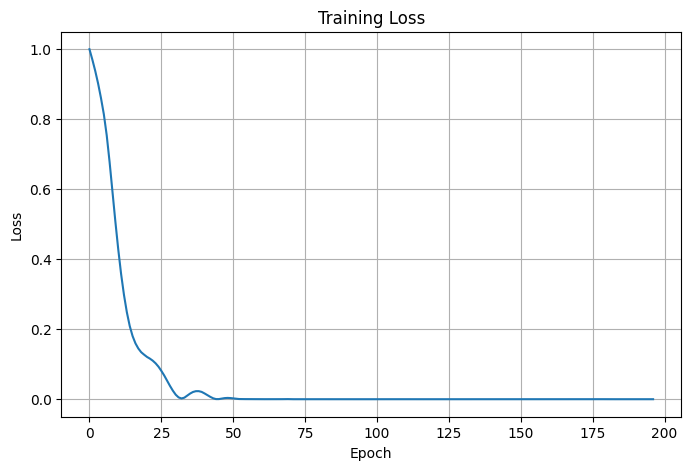

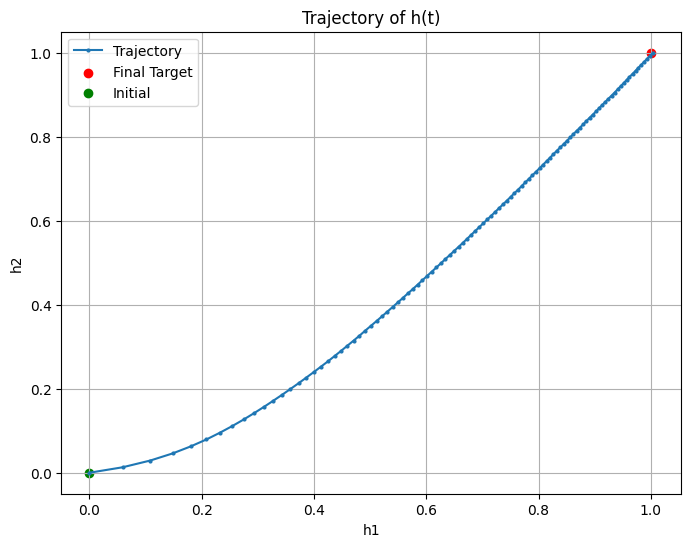

In [13]:
# ----------------------------
# Testing the Neural ODE on a simple regression task
# ----------------------------
def main():
    #hyperparameters for layer size (can adjust size of hidden_dim of the neural network)
    input_dim = 2
    hidden_dim = 64  
    output_dim = 2
    
    neural_net = NeuralNet(input_dim, hidden_dim, output_dim)
    neural_ode = NeuralODE(neural_net, t0=0.0, tf=1.0, dt=0.01)
    
    #simple trajectory from point A to B
    h0 = np.array([[0.0], [0.0]])
    target = np.array([[1.0], [1.0]])
 
    # hyperparameters for training
    epochs = 2000  
    lr = 1e-3      
    print_every = 100
    
    loss_history = train_neural_ode(neural_ode, h0, target, epochs, lr, print_every)
    
    # plotting loss history
    plt.figure(figsize=(8,5))
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()
    
    # plotting trajectory
    trajectory = neural_ode.integrate_forward(h0)
    hs = np.array([h for t, h in trajectory])  
    hs = hs.squeeze(-1)  
    
    plt.figure(figsize=(8,6))
    plt.plot(hs[:,0], hs[:,1], marker='o', markersize=2, label='Trajectory')
    

    plt.scatter(target[0], target[1], color='red', label='Final Target')
    plt.scatter(h0[0], h0[1], color='green', label='Initial')
    plt.xlabel('h1')
    plt.ylabel('h2')
    plt.title('Trajectory of h(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()